<a href="https://colab.research.google.com/github/PranshuKala/102116070-SESS_LE1/blob/main/102116070_PranshuKala.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [5]:
!pip install -U -q tensorflow tensorflow_datasets

In [2]:
import os
import librosa
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

dataset_path = '/content/drive/MyDrive/Speech-Dataset'


In [2]:
commands = [d for d in os.listdir(dataset_path) if os.path.isdir(os.path.join(dataset_path, d))]
commands.sort()
print(f"Commands: {commands}")
print(f"Number of commands:" , {len(commands)})

Commands: ['_background_noise_', 'backward', 'bed', 'bird', 'cat', 'dog', 'down', 'eight', 'five', 'follow', 'forward', 'four', 'go', 'happy', 'house', 'learn', 'left', 'marvin', 'nine', 'no', 'off', 'on', 'one', 'right', 'seven', 'sheila', 'six', 'stop', 'three', 'tree', 'two', 'up', 'visual', 'wow', 'yes', 'zero']
Number of commands: {36}


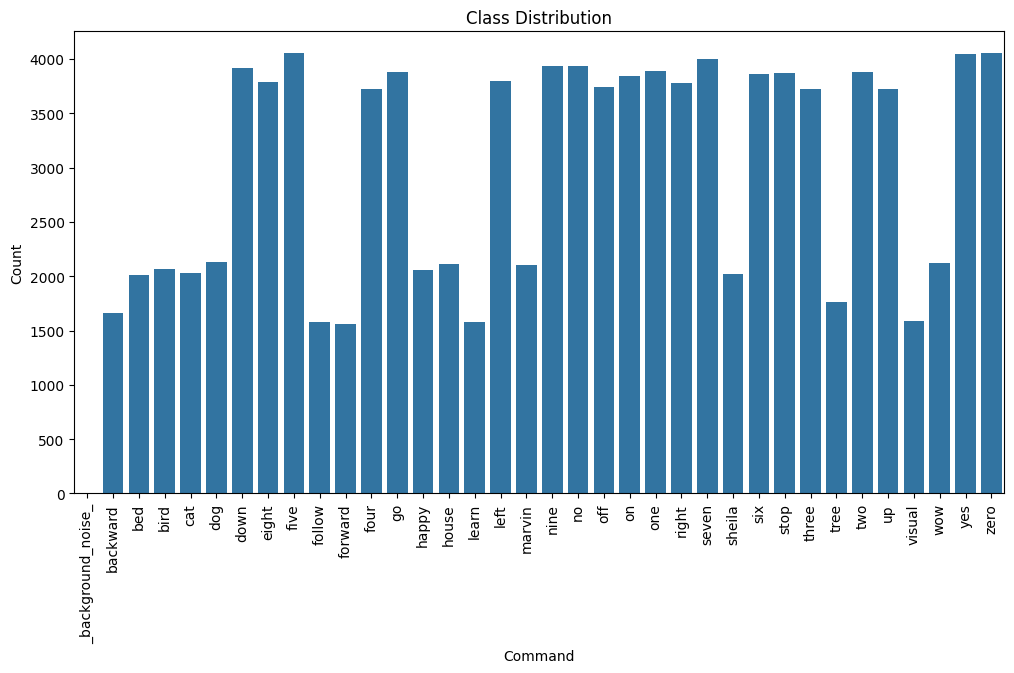

In [ ]:
# Count the number of files per class (command)
file_count_per_class = {command: len(os.listdir(os.path.join(dataset_path, command))) for command in commands}

# Create a DataFrame for easy analysis
df_class_distribution = pd.DataFrame(list(file_count_per_class.items()), columns=['Command', 'Count'])


plt.figure(figsize=(12, 6))
sns.barplot(x='Command', y='Count', data=df_class_distribution)
plt.xticks(rotation=90)
plt.title('Class Distribution')
plt.show()


In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


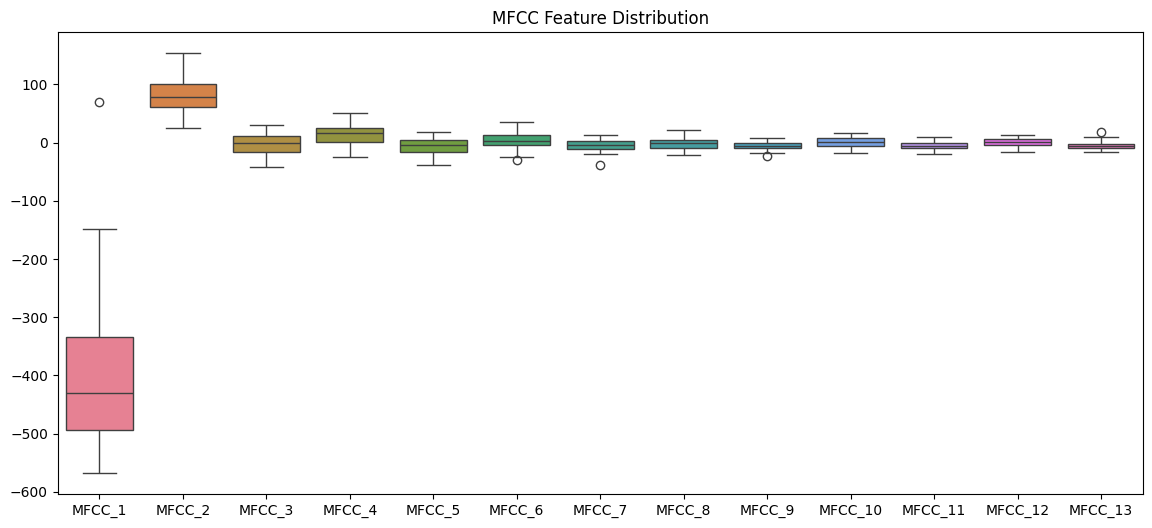

In [ ]:
# Extract MFCCs for a sample from each class
mfccs = []
labels = []

for command in commands:
    folder_path = os.path.join(dataset_path, command)
    file_path = os.path.join(folder_path, os.listdir(folder_path)[0])  # Take the first file from each class
    y, sr = librosa.load(file_path, sr=16000)
    mfcc = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=13)
    mfccs.append(np.mean(mfcc, axis=1))  # Take mean of MFCC across frames
    labels.append(command)


df_mfcc = pd.DataFrame(mfccs, columns=[f'MFCC_{i}' for i in range(1, 14)])
df_mfcc['Label'] = labels


plt.figure(figsize=(14, 6))
sns.boxplot(data=df_mfcc.drop('Label', axis=1))
plt.title('MFCC Feature Distribution')
plt.show()


In [ ]:
!pip install librosa tensorflow pandas matplotlib


In [ ]:
import os
import librosa
import numpy as np
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
import matplotlib.pyplot as plt



SAMPLE_RATE = 16000  # 16kHz sampling rate
N_MFCC = 13          # Number of MFCC features
AUDIO_DURATION = 1   # 1 second duration
N_CLASSES = 10       # Number of commands to classify


commands = ['yes', 'no', 'up', 'down', 'left', 'right', 'on', 'off', 'stop', 'go']


def load_audio_files(dataset_path, commands):
    X = []
    y = []
    for label in commands:
        folder_path = os.path.join(dataset_path, label)
        for filename in os.listdir(folder_path):
            file_path = os.path.join(folder_path, filename)
            # Load the audio file and ensure it's the correct length
            y_audio, sr = librosa.load(file_path, sr=SAMPLE_RATE, duration=AUDIO_DURATION)
            # Extract MFCC features
            mfcc = librosa.feature.mfcc(y=y_audio, sr=sr, n_mfcc=N_MFCC)
            mfcc = np.mean(mfcc.T, axis=0)  # Take mean across time
            X.append(mfcc)
            y.append(label)
    return np.array(X), np.array(y)


X, y = load_audio_files(dataset_path, commands)

label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)


X_train, X_test, y_train, y_test = train_test_split(X, y_encoded, test_size=0.2, random_state=42)

# Normalize features
X_train = X_train / np.max(np.abs(X_train), axis=0)
X_test = X_test / np.max(np.abs(X_test), axis=0)

print(f"Training set size: {X_train.shape}")
print(f"Test set size: {X_test.shape}")


Training set size: (30836, 13)
Test set size: (7710, 13)


In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout

def build_model(input_shape, n_classes):
    model = Sequential()
    model.add(Dense(256, input_shape=(input_shape,), activation='relu'))
    model.add(Dropout(0.3))
    model.add(Dense(128, activation='relu'))
    model.add(Dropout(0.3))
    model.add(Dense(64, activation='relu'))
    model.add(Dropout(0.3))
    model.add(Dense(n_classes, activation='softmax'))

    model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    return model


model = build_model(X_train.shape[1], len(commands))


model.summary()


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense (Dense)                        │ (None, 256)                 │           3,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 128)                 │          32,896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 64)                  │           8,256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 10)                  │             650 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 45,386 (177.29 KB)

 Trainable params: 45,386 (177.29 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/40
771/771 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.4542 - loss: 1.5548 - val_accuracy: 0.4488 - val_loss: 1.5684
Epoch 2/40
771/771 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.4548 - loss: 1.5559 - val_accuracy: 0.4506 - val_loss: 1.5621
Epoch 3/40
771/771 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.4491 - loss: 1.5508 - val_accuracy: 0.4517 - val_loss: 1.5589
Epoch 4/40
771/771 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.4484 - loss: 1.5520 - val_accuracy: 0.4530 - val_loss: 1.5578
Epoch 5/40
771/771 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.4513 - loss: 1.5562 - val_accuracy: 0.4517 - val_loss: 1.5538
Epoch 6/40
771/771 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.4524 - loss: 1.5454 - val_accuracy: 0.4528 - val_loss: 1.5524
Epoch 7/40
771/771 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.4566 - loss: 1.5411 - val_accuracy: 0.4515 - val_loss: 1.5556
Epoch 8/40
771/771 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.4586 - loss: 1.5336 - val_accuracy: 0.

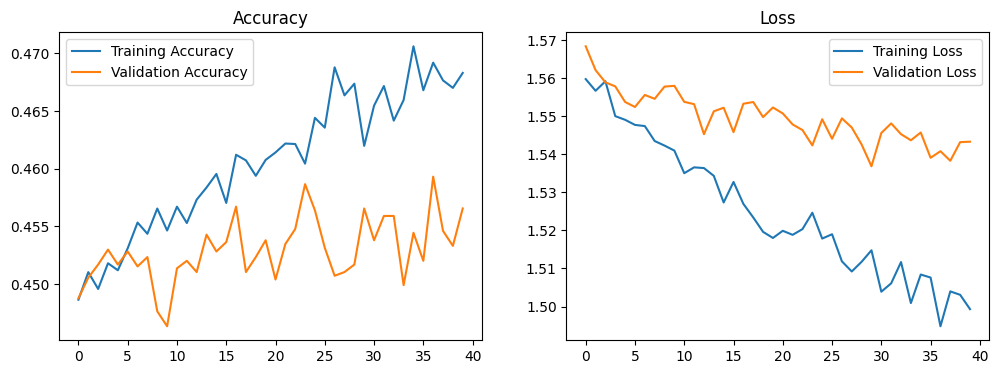

In [ ]:

history = model.fit(X_train, y_train, epochs=40, batch_size=32, validation_split=0.2)


plt.figure(figsize=(12, 4))


plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.legend()
plt.title('Accuracy')


plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.legend()
plt.title('Loss')

plt.show()


In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, GlobalAveragePooling1D, BatchNormalization, Dense, Dropout, Activation

# Build an improved CNN-based model
def build_improved_model(input_shape, n_classes):
    model = Sequential()


    model.add(Conv1D(128, kernel_size=5, strides=1, padding='same', input_shape=(input_shape, 1)))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    model.add(MaxPooling1D(pool_size=2))

    model.add(Conv1D(128, kernel_size=5, strides=1, padding='same'))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    model.add(MaxPooling1D(pool_size=2))


    model.add(Conv1D(256, kernel_size=5, strides=1, padding='same'))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    model.add(MaxPooling1D(pool_size=2))


    model.add(GlobalAveragePooling1D())


    model.add(Dense(128, activation='relu'))
    model.add(Dropout(0.3))

    model.add(Dense(n_classes, activation='softmax'))


    model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

    return model


X_train_reshaped = X_train[..., np.newaxis]
X_test_reshaped = X_test[..., np.newaxis]


improved_model = build_improved_model(X_train_reshaped.shape[1], len(commands))


improved_model.summary()


/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv1d (Conv1D)                      │ (None, 13, 128)             │             768 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 13, 128)             │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation (Activation)              │ (None, 13, 128)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling1d (MaxPooling1D)         │ (None, 6, 128)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d_1 (Conv1D)                    │ (None, 6, 128)              │          82,048 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_1                │ (None, 6, 128)              │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_1 (Activation)            │ (None, 6, 128)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling1d_1 (MaxPooling1D)       │ (None, 3, 128)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d_2 (Conv1D)                    │ (None, 3, 256)              │         164,096 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_2                │ (None, 3, 256)              │           1,024 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_2 (Activation)            │ (None, 3, 256)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling1d_2 (MaxPooling1D)       │ (None, 1, 256)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling1d             │ (None, 256)                 │               0 │
│ (GlobalAveragePooling1D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ (None, 128)                 │          32,896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_3 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_5 (Dense)                      │ (None, 10)                  │           1,290 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 283,146 (1.08 MB)

 Trainable params: 282,122 (1.08 MB)

 Non-trainable params: 1,024 (4.00 KB)

Epoch 1/20
771/771 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.4743 - loss: 1.4795 - val_accuracy: 0.4567 - val_loss: 1.5401
Epoch 2/20
771/771 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.4740 - loss: 1.4907 - val_accuracy: 0.4569 - val_loss: 1.5391
Epoch 3/20
771/771 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.4747 - loss: 1.4820 - val_accuracy: 0.4572 - val_loss: 1.5404
Epoch 4/20
771/771 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.4620 - loss: 1.4993 - val_accuracy: 0.4559 - val_loss: 1.5431
Epoch 5/20
771/771 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.4696 - loss: 1.4866 - val_accuracy: 0.4619 - val_loss: 1.5365
Epoch 6/20
771/771 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.4740 - loss: 1.4910 - val_accuracy: 0.4531 - val_loss: 1.5483
Epoch 7/20
771/771 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.4680 - loss: 1.4994 - val_accuracy: 0.4601 - val_loss: 1.5478
Epoch 8/20
771/771 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.4685 - loss: 1.4918 - val_accuracy: 0.

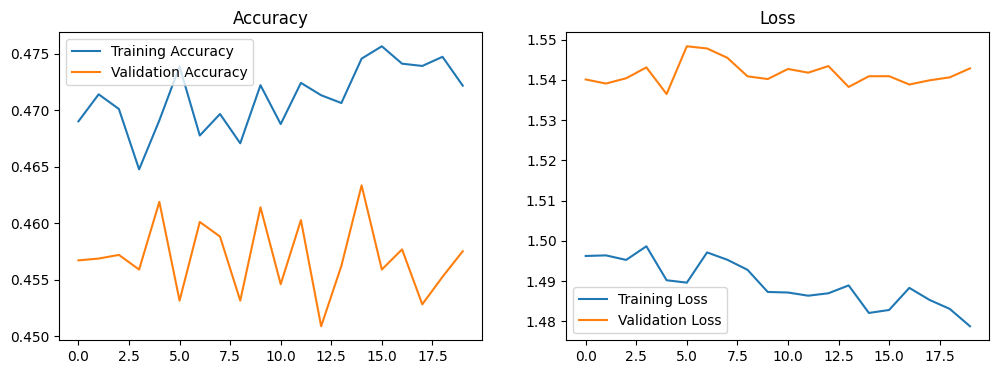

In [ ]:

history = model.fit(X_train, y_train, epochs=20, batch_size=32, validation_split=0.2)

plt.figure(figsize=(12, 4))


plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.legend()
plt.title('Accuracy')


plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.legend()
plt.title('Loss')

plt.show()

In [ ]:
from tensorflow.keras.layers import LSTM, TimeDistributed

def build_cnn_rnn_model(input_shape, n_classes):
    model = Sequential()


    model.add(Conv1D(128, kernel_size=5, strides=1, padding='same', input_shape=(input_shape, 1)))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    model.add(MaxPooling1D(pool_size=2))

    model.add(Conv1D(128, kernel_size=5, strides=1, padding='same'))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    model.add(MaxPooling1D(pool_size=2))

    # RNN layer
    model.add(LSTM(64, return_sequences=False))


    model.add(Dense(128, activation='relu'))
    model.add(Dropout(0.3))

    model.add(Dense(n_classes, activation='softmax'))

    model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    return model


X_train_reshaped = X_train[..., np.newaxis]
model = build_cnn_rnn_model(X_train_reshaped.shape[1], len(commands))
model.summary()


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv1d_3 (Conv1D)                    │ (None, 13, 128)             │             768 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_3                │ (None, 13, 128)             │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_3 (Activation)            │ (None, 13, 128)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling1d_3 (MaxPooling1D)       │ (None, 6, 128)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d_4 (Conv1D)                    │ (None, 6, 128)              │          82,048 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_4                │ (None, 6, 128)              │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_4 (Activation)            │ (None, 6, 128)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling1d_4 (MaxPooling1D)       │ (None, 3, 128)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm (LSTM)                          │ (None, 64)                  │          49,408 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_6 (Dense)                      │ (None, 128)                 │           8,320 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_4 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_7 (Dense)                      │ (None, 10)                  │           1,290 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 142,858 (558.04 KB)

 Trainable params: 142,346 (556.04 KB)

 Non-trainable params: 512 (2.00 KB)

Epoch 1/30
1542/1542 ━━━━━━━━━━━━━━━━━━━━ 13s 8ms/step - accuracy: 0.5301 - loss: 1.3080 - val_accuracy: 0.4473 - val_loss: 1.6298
Epoch 2/30
1542/1542 ━━━━━━━━━━━━━━━━━━━━ 21s 8ms/step - accuracy: 0.5433 - loss: 1.2628 - val_accuracy: 0.4436 - val_loss: 1.6520
Epoch 3/30
1542/1542 ━━━━━━━━━━━━━━━━━━━━ 22s 9ms/step - accuracy: 0.5632 - loss: 1.2229 - val_accuracy: 0.4497 - val_loss: 1.6466
Epoch 4/30
1542/1542 ━━━━━━━━━━━━━━━━━━━━ 13s 8ms/step - accuracy: 0.5573 - loss: 1.2197 - val_accuracy: 0.4389 - val_loss: 1.7040
Epoch 5/30
1542/1542 ━━━━━━━━━━━━━━━━━━━━ 14s 9ms/step - accuracy: 0.5631 - loss: 1.1978 - val_accuracy: 0.4554 - val_loss: 1.6794
Epoch 6/30
1542/1542 ━━━━━━━━━━━━━━━━━━━━ 20s 8ms/step - accuracy: 0.5757 - loss: 1.1610 - val_accuracy: 0.4523 - val_loss: 1.6888
Epoch 7/30
1542/1542 ━━━━━━━━━━━━━━━━━━━━ 21s 9ms/step - accuracy: 0.5876 - loss: 1.1341 - val_accuracy: 0.4491 - val_loss: 1.7069
Epoch 8/30
1542/1542 ━━━━━━━━━━━━━━━━━━━━ 20s 8ms/step - accuracy: 0.5982 - loss: 1

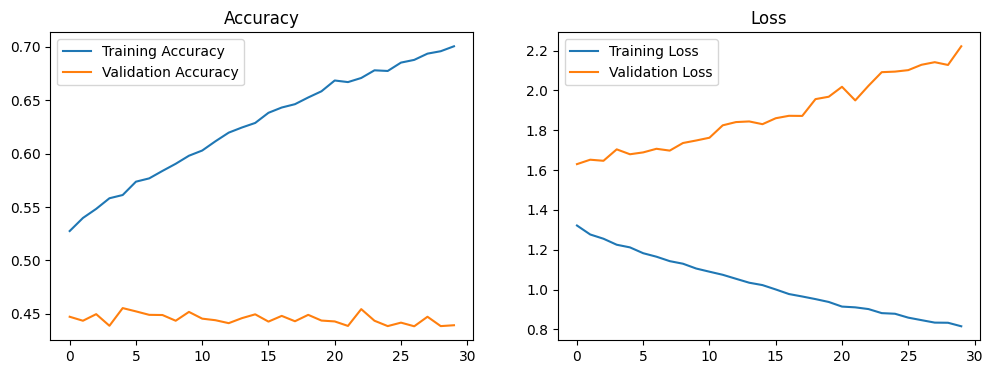

In [ ]:

history = model.fit(X_train, y_train, epochs=30, batch_size=16, validation_split=0.2)


plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.legend()
plt.title('Accuracy')

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.legend()
plt.title('Loss')

plt.show()

In [ ]:
# Save the trained model to a file
model.save('speech_command_model.keras')


In [ ]:
import numpy as np


X_train_path = 'X_train.npy'
X_test_path = 'X_test.npy'
y_train_path = 'y_train.npy'
y_test_path = 'y_test.npy'


np.save(X_train_path, X_train)
np.save(X_test_path, X_test)
np.save(y_train_path, y_train)
np.save(y_test_path, y_test)

print(f"Datasets saved successfully to:\n{X_train_path}\n{X_test_path}\n{y_train_path}\n{y_test_path}")


Datasets saved successfully to:
X_train.npy
X_test.npy
y_train.npy
y_test.npy


In [26]:
from tensorflow.keras.models import load_model


loaded_model = load_model('/content/drive/MyDrive/Assests_102116070/speech_command_model.keras')


/usr/local/lib/python3.10/dist-packages/keras/src/saving/saving_lib.py:576: UserWarning: Skipping variable loading for optimizer 'rmsprop', because it has 17 variables whereas the saved optimizer has 32 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


In [5]:

my_dataset_path = '/content/drive/MyDrive/Assests_102116070/my_voice_commands/Pranshu'


def preprocess_audio_files(dataset_path, commands):
    X = []
    y = []
    for label in commands:
        folder_path = os.path.join(dataset_path, label)
        for filename in os.listdir(folder_path):
            file_path = os.path.join(folder_path, filename)

            y_audio, sr = librosa.load(file_path, sr=16000, duration=1)
            mfcc = librosa.feature.mfcc(y=y_audio, sr=sr, n_mfcc=13)
            mfcc = np.mean(mfcc.T, axis=0)
            X.append(mfcc)
            y.append(label)
    return np.array(X), np.array(y)


commands = ['yes', 'no', 'up', 'down', 'left', 'right', 'on', 'off', 'stop', 'go']
X_my_voice, y_my_voice = preprocess_audio_files(my_dataset_path, commands)


from sklearn.preprocessing import LabelEncoder
label_encoder = LabelEncoder()
y_my_voice_encoded = label_encoder.fit_transform(y_my_voice)


In [27]:
from sklearn.model_selection import train_test_split

X_train_my_voice, X_test_my_voice, y_train_my_voice, y_test_my_voice = train_test_split(
    X_my_voice, y_my_voice_encoded, test_size=0.2, random_state=42
)


history = loaded_model.fit(X_train_my_voice, y_train_my_voice, epochs=20, batch_size=2, validation_split=0.2)


loaded_model.save('fine_tuned_speech_command_model.keras')


Epoch 1/20
96/96 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/step - accuracy: 0.2531 - loss: 2.3461 - val_accuracy: 0.3958 - val_loss: 1.7037
Epoch 2/20
96/96 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.4417 - loss: 1.4133 - val_accuracy: 0.6250 - val_loss: 0.8329
Epoch 3/20
96/96 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.6124 - loss: 0.9575 - val_accuracy: 0.7500 - val_loss: 0.8040
Epoch 4/20
96/96 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.6223 - loss: 1.0767 - val_accuracy: 0.7292 - val_loss: 0.8515
Epoch 5/20
96/96 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.7108 - loss: 0.9161 - val_accuracy: 0.7708 - val_loss: 0.6772
Epoch 6/20
96/96 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.6610 - loss: 0.9810 - val_accuracy: 0.7292 - val_loss: 0.7202
Epoch 7/20
96/96 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.6918 - loss: 0.8166 - val_accuracy: 0.7500 - val_loss: 0.7951
Epoch 8/20
96/96 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.7360 - loss: 0.7599 - val_accuracy: 0.7708 - val_loss

In [30]:
loss, accuracy = loaded_model.evaluate(X_test_my_voice, y_test_my_voice)
print(f"Test accuracy after fine-tuning: {accuracy}")


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.7819 - loss: 0.4879 
Test accuracy after fine-tuning: 0.7666666507720947
